# Group 16 Milestone 1

In [1]:
import os
import os.path
import zipfile
import requests
import json
import pandas as pd
from urllib.request import urlretrieve
import glob
import re

In [2]:
# Necessary metadata
url = "https://api.figshare.com/v2/articles/14096681"
headers = {"Content-Type": "application/json"}
output_directory = "../data/"
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)
files = data["files"]

In [3]:
%%time
files_to_dl = "data.zip"
if not os.path.isfile(output_directory + files_to_dl):
    for file in files:
        if file["name"] == files_to_dl:
            os.makedirs(output_directory, exist_ok=True)
            urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: user 369 µs, sys: 120 µs, total: 489 µs
Wall time: 429 µs


In [4]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, files_to_dl), "r") as f:
    f.extractall(output_directory)
os.remove("../data/observed_daily_rainfall_SYD.csv")

CPU times: user 14.6 s, sys: 952 ms, total: 15.6 s
Wall time: 16.2 s


In [5]:
%%time
files = glob.glob("../data/*.csv")
columns = ["time", "lat_min", "lat_max", "lon_min", "lon_max", "rain (mm/day)"]
df = pd.concat((pd.read_csv(file, index_col=0, usecols=columns)
                .assign(model=re.findall(r"[^\/]+(?=\_daily)", file)[0])
                for file in files)
              )

CPU times: user 38.9 s, sys: 5.78 s, total: 44.7 s
Wall time: 48.6 s


In [6]:
df

,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
time,,,,,,
1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM
...,...,...,...,...,...,...
2014-12-27 12:00:00,-30.157068,-29.214660,153.1250,154.3750,6.689683e+00,SAM0-UNICON
2014-12-28 12:00:00,-30.157068,-29.214660,153.1250,154.3750,7.862555e+00,SAM0-UNICON
2014-12-29 12:00:00,-30.157068,-29.214660,153.1250,154.3750,1.000503e+01,SAM0-UNICON


## Runtimes of CSV compilation


| Team Member | OS           | RAM | Processor        | Is SSD | Wall Time Taken |
|-------------|--------------|-----|------------------|--------|-----------------|
| Nikita      | Ubuntu 20.04 | 8GB | 8th Gen Core i7  | Yes    | 1min 32s        |
| Margot      |              |     |                  |        |                 |
| Thea        |              |     |                  |        |                 |
| Kiran       |    MacOS Big Sur          |   8GB  |     Apple M1 chip            |    Yes    |        1min 40s         |

## EDA for R

In [7]:
%load_ext rpy2.ipython

**In order to select which method is the most appropriate to transfer the dataframe from python to R, we chose to try all methods and observe which method was more suitable for us (the code and output of the methods that were not selected are placed in markdown cells):**

### Parquet Method

```
%%time
df.to_parquet("../data/rainfall.parquet")

>>> CPU times: user 22.3 s, sys: 5.77 s, total: 28.1 s
Wall time: 30.1 s
```
<br/><br/>

```
%%time
%%R
library(dplyr)
library(arrow)
parquet_rdf <- read_parquet("../data/rainfall.parquet") |> collect()

>>> CPU times: user 4.42 s, sys: 4.37 s, total: 8.8 s
Wall time: 8.37 s
```

### Feather Method

```
%%time
import pyarrow.feather as feather
feather.write_feather(df, '../data/rainfall.feather')

>>> CPU times: user 4.5 s, sys: 4.45 s, total: 8.95 s
Wall time: 6.89 s
```
<br/><br/>

```
%%time
%%R
feather_rdf <- read_feather("../data/rainfall.feather") |> collect()

>>> CPU times: user 1.09 s, sys: 1.84 s, total: 2.93 s
Wall time: 4.31 s
```

### Arrow Exchange Method

In [8]:
import rpy2.robjects.conversion
import pyarrow
import rpy2.rinterface
import rpy2_arrow.pyarrow_rarrow as pyra
from rpy2.robjects.packages import importr

In [9]:
%%time
arrow_rframe = pyra.converter.py2rpy(pyarrow.Table.from_pandas(df))

CPU times: user 10.9 s, sys: 3.84 s, total: 14.7 s
Wall time: 13.7 s


In [10]:
%%time
%%R -i arrow_rframe
library(dplyr)
library(ggplot2)
arrow_rframe <- arrow_rframe |> collect()

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




CPU times: user 254 ms, sys: 112 ms, total: 366 ms
Wall time: 694 ms


### Checking size of different files

In [11]:
b = 0
for file in files:
    b = os.path.getsize(file)
    b += b
b * 1e-6

666.979758

In [12]:
os.path.getsize("../data/rainfall.feather")*1e-6

716.238154

In [13]:
os.path.getsize("../data/rainfall.parquet")*1e-6

701.2660629999999

**Summary of different transfer methods:**


| Method | Estimated time to transfer | File memory |
| --- | --- | --- |
| Arrow Exchange | 9s | 667 MB |
| Feather file | 11s | 716 MB |
| Parquet file | 27s | 701 MB |

**Justification:** The 'Arrow Exchange' method appeared to speed up the conversion of a pandas DataFrame into tabular data that is accessible for R. We opted for this method since it decreases the time spent during the serialization and de-serialization process while also avoiding the creation of unnecessary copies of the data. In addition to this, the file storage format appears to be slightly less memory-intensive compared to the other file storage formats. Altogether, the 'Arrow Exchange' method appeared to be the most appropriate for our purposes.

### EDA

**Structure of the Data:**

In [14]:
%%R
str(arrow_rframe)

tibble [62,467,843 × 7] (S3: tbl_df/tbl/data.frame)
 $ lat_min      : num [1:62467843] -35.4 -35.4 -35.4 -35.4 -35.4 ...
 $ lat_max      : num [1:62467843] -33.6 -33.6 -33.6 -33.6 -33.6 ...
 $ lon_min      : num [1:62467843] 142 142 142 142 142 ...
 $ lon_max      : num [1:62467843] 143 143 143 143 143 ...
 $ rain (mm/day): num [1:62467843] 4.24e-13 4.22e-13 4.50e-13 4.25e-13 4.27e-13 ...
 $ model        : chr [1:62467843] "MPI-ESM-1-2-HAM" "MPI-ESM-1-2-HAM" "MPI-ESM-1-2-HAM" "MPI-ESM-1-2-HAM" ...
 $ time         : chr [1:62467843] "1889-01-01 12:00:00" "1889-01-02 12:00:00" "1889-01-03 12:00:00" "1889-01-04 12:00:00" ...


**Summary Statistics For Each Columns**

In [15]:
%%R
arrow_rframe |> summary()

    lat_min           lat_max          lon_min           lon_max     
 Min.   :-36       Min.   :-36.00   Min.   :141       Min.   :141.2  
 1st Qu.:-35       1st Qu.:-33.66   1st Qu.:143       1st Qu.:145.0  
 Median :-33       Median :-32.04   Median :147       Median :148.1  
 Mean   :-33       Mean   :-31.98   Mean   :147       Mean   :148.2  
 3rd Qu.:-31       3rd Qu.:-30.16   3rd Qu.:150       3rd Qu.:151.3  
 Max.   :-30       Max.   :-27.91   Max.   :154       Max.   :155.6  
 NA's   :3219300                    NA's   :3219300                  
 rain (mm/day)        model               time          
 Min.   :  0       Length:62467843    Length:62467843   
 1st Qu.:  0       Class :character   Class :character  
 Median :  0       Mode  :character   Mode  :character  
 Mean   :  2                                            
 3rd Qu.:  1                                            
 Max.   :433                                            
 NA's   :3219300                         

**Mean Rainfall (mm/day) Computed For Each Model**

In [20]:
%%R
library(dplyr)
df1 <- arrow_rframe |> group_by(model) |> summarize(mean_rainfall = mean(`rain (mm/day)`), na.rm=TRUE) |> arrange(desc(mean_rainfall))

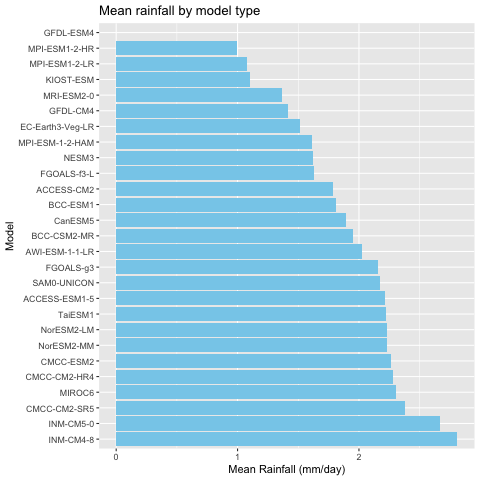

In [29]:
%%R
df1 |> ggplot() +
    aes(x = mean_rainfall, y = reorder(model, -mean_rainfall)) +
    geom_bar(stat = "identity", fill = "skyblue") +
    labs(x = "Mean Rainfall (mm/day)", y = "Model", title = "Mean rainfall by model type")

**Counts of Different Models:**

In [18]:
%%R
df2 <- arrow_rframe |> count(model) |> arrange(desc(n))
df2

# A tibble: 27 × 2
   model               n
   <chr>           <int>
 1 MPI-ESM1-2-HR 5154240
 2 CMCC-CM2-HR4  3541230
 3 CMCC-CM2-SR5  3541230
 4 CMCC-ESM2     3541230
 5 NorESM2-MM    3541230
 6 TaiESM1       3541230
 7 SAM0-UNICON   3541153
 8 FGOALS-f3-L   3219300
 9 GFDL-CM4      3219300
10 GFDL-ESM4     3219300
# … with 17 more rows


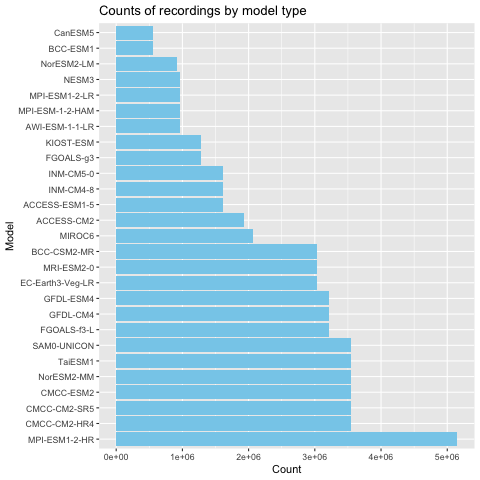

In [30]:
%%R
df2 |> ggplot() +
    geom_bar(aes(x = n, y = reorder(model, -n)), stat="identity", fill = "skyblue") +
    labs(x = "Count", y = "Model", title = "Counts of recordings by model type")